# Medical Imaging Preprocessing

> A walk-through tutorial how to process, manipulate, and save medical images. 
- toc: true
- use_math: true
- comments: true
- use_plotly: true

- read dicom
- metadata
- resampling
- segmentation (by HU)

# Background

In this tutorial, we will review how to process, handle, and save DICOM data. A great resource to access medical imaging data is through the [Cancer Imaging Archive](https://www.cancerimagingarchive.net/collections/). They maintain an archive of medical images across various datasets that are accessible for public download. We will be using scans from the [LIDC-IDRI](https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX) dataset which contains diagnostic and lung cancer screening thoracic computed tomography (CT) scans with annotated lesions in XML format. To handle the annotated lessions, researchers have developed the [pylidc](https://pylidc.github.io/tuts/scan.html) for processing the XML files. 

In [1]:
#hide
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom
import scipy.ndimage

from pathlib import Path

In [2]:
#hide
PATH = 'data/LIDC-IDRI'

patients = os.listdir(PATH)
patients.sort()
print(patients.pop(0))
patients

.ipynb_checkpoints


['LIDC-IDRI-0001',
 'LIDC-IDRI-0002',
 'LIDC-IDRI-0003',
 'LIDC-IDRI-0004',
 'LIDC-IDRI-0005',
 'LIDC-IDRI-0006',
 'LIDC-IDRI-0007',
 'LIDC-IDRI-0008',
 'LIDC-IDRI-0009',
 'LIDC-IDRI-0010',
 'LIDC-IDRI-0011']

In [3]:
#hide
# not all patient sub-folders contain CT scan, sometimes they're RTSTRUCTs 

patient_path = []
for p in patients:
    patient_directory = glob.glob(f"{PATH}/{p}/**/")
    for mod in patient_directory:
        mod_files = glob.glob(f"{mod}/**/**")
        if len(mod_files) > 10: patient_path.append(mod)
patient_path

['data/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/',
 'data/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-NA-NA-98329/',
 'data/LIDC-IDRI/LIDC-IDRI-0003/01-01-2000-NA-NA-94866/',
 'data/LIDC-IDRI/LIDC-IDRI-0004/01-01-2000-NA-NA-91780/',
 'data/LIDC-IDRI/LIDC-IDRI-0005/01-01-2000-NA-NA-42125/',
 'data/LIDC-IDRI/LIDC-IDRI-0006/01-01-2000-NA-NA-92500/',
 'data/LIDC-IDRI/LIDC-IDRI-0007/01-01-2000-NA-NA-81781/',
 'data/LIDC-IDRI/LIDC-IDRI-0008/01-01-2000-NA-NA-30141/',
 'data/LIDC-IDRI/LIDC-IDRI-0009/01-01-2000-NA-NA-07045/',
 'data/LIDC-IDRI/LIDC-IDRI-0010/01-01-2000-NA-NA-43375/',
 'data/LIDC-IDRI/LIDC-IDRI-0011/01-01-2000-NA-NA-73568/']

## DICOM files

Without going into intensive detail, we should know that CT scans produce an image by producing cross-sectional images from an X-Ray and then reconstruct the slices to form a volumetric image. Each slice is saved to a DICOM file which stores the pixel array and metadata for that particular slice. We can sort the list of DICOM files by the image position of the patient to construct a volumetric image and then sort the slices in ascending order. If you're interested in learning about the physics of medical imaging and how images are produced, I recommend [Fundamentals of Medical Imaging](https://doi.org/10.1017/CBO9780511596803).

In [4]:
def load_scan(path):
    slices = [pydicom.read_file(f"{s}") for s in glob.glob(f"{path}/**/*.dcm")]
    # sort slices vertically - bottom up
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    return slices

After sorting DICOM files by ```ImagePositionPatient```, we can load the DICOM files in the correct order. Looking at the first DICOM file, we can see all the metadata information that is stored. We'll need this to process and store our data in a more appropriate format.

In [5]:
scan = load_scan(patient_path[0])
scan[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.227129408140157230270926028555
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.22712

DICOM or Digital Imaging and Communications in Medicine is a standardized file format for medical imaging information and related data. Typically, you will see the raw medical images stored in this format and later processed to an easier to handle format such as [NIfTI](https://radiopaedia.org/articles/nifti-file-format#:~:text=NIfTI%20is%20a%20type%20of,neuroscience%20and%20even%20neuroradiology%20research.) or [Nrrd](http://teem.sourceforge.net/nrrd/format.html). To process our DICOM files, we are using the ```pydicom``` library and have constructed and read a list of ```pydicom.dataset.FileDataset``` objects with our ```scan``` list. This object allows to access any relevant data elements stored in the DICOM file, useful data elements include ```Modality, RescaleIntercept, RescaleSlope, PixelSpacing, SliceThickness,``` and ```ImagePositionPatient```. We'll need these data elements to standardize our scans to the same pixel spacing and covert our pixel values to the Hounsfield scale. It could also be helpful to use these data elements and construct an array of metadata elements to use for training. This is particularly useful in case you want to identify any subtleties between CT manufacturers. The [DICOM library](https://www.dicomlibrary.com/dicom/dicom-tags/) has an exhaustive list of all the data elements and there use. You will also notice the following standardized format for DICOM data elements:
- a tag that identifies the attribute, usually in the format (XXXX,XXXX) with hexadecimal numbers, and may be divided further into DICOM Group Number and DICOM Element Number;
- a DICOM Value Representation (VR) that describes the data type and format of the attribute value.

In [6]:
# ??pydicom.dataset.FileDataset

In [7]:
# type(scan[0])

## Hounsfield Scale

For CT scans, we are able to acquire an image by measuring how much the object attenuates the incidence X-Rays. The more dense the object, the greater it attenuates the incidence waves. From this object-wave interaction, we can expand this relationship to various tissue types and estimate tissues based on the energy received. The quantitative value describing this radiodensity is known as the Hounsfield scale also termed CT number when used for CT scans. A list of various tissue types and their HU value can be seen below.

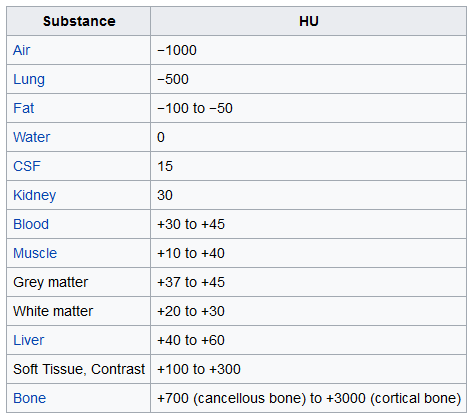

In [8]:
#hide_input
from IPython.display import Image
Image(filename='../assets/blogs/2022_01_24/hu_scale.png')

In [9]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # check that every slice has same slope and intercept
    assert len(set([s.RescaleSlope for s in slices])) == 1
    assert len(set([s.RescaleIntercept for s in slices])) == 1
    
    # slope and intercept to convert to HU
    slope = scan[0].RescaleSlope
    intercept = scan[0].RescaleIntercept
    
    # Convert to Hounsfield units (HU)
    image = image.astype(np.float64) * slope
    image += np.int16(intercept)
    
    # Set outside-of-scan pixels to air
    # this step is completly optional
    # w/o it there'll be a cylinder around the body as seen in the DICOM pixel array below
    image[image < -1024] = -1024
    
    return np.array(image, dtype=np.int16)

The pixel information in the DICOM file does not store the exact HU number. However, it stores the slope and intercept value needed to scale these pixels to their respective HU number. This linear relationship is described below:

$\textrm{HU} = \textrm{pixel_value} \times \textrm{slope} + \textrm{intercept}$

<br>
After processing our pixel array and converting it to Hounsfield scale, we can check the distribution of value. This bimodal distribution stems from the drastic differences in tissue properties in the acquire image. The air in the lungs and outside the body range from -1000 to -500 HU while more denser materials such as fat and cortical bone provide higher HU values of -100 to +3000 HU respectively. We'll need to remember this subtlety when normalizing our images later.

scan_data.min()=-1024, scan_data.max()=3071


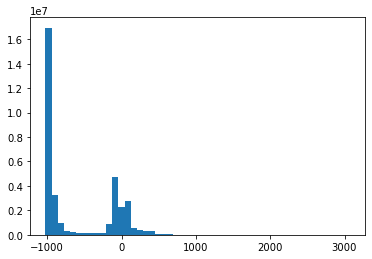

In [10]:
scan_data = get_pixels_hu(scan)
plt.hist(scan_data.ravel(), bins=50)
print(f"{scan_data.min()=}, {scan_data.max()=}")
plt.show()

Since we're working with grayscale images, the intensity of the black varies according to the minimum and maximum values. The black pixels in the HU images are equivalent (-1024 HU) to the pixels in the lung and outside the body for the raw DICOM pixel array. Since we masked all pixels < -1024, we no longer obtain a cylinder surrounding the body and set them all equivalent to air. If you're curious why we're obtaining a circle around each slice, it's because of the CT scan itself and how it emits and receives X-Rays all around the patient's body.

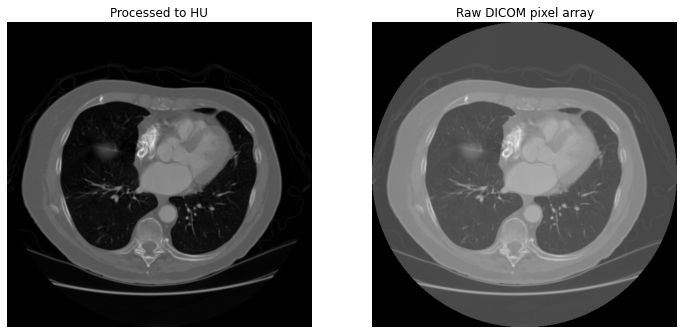

In [11]:
f, axs = plt.subplots(1,2, figsize=(12,12))

axs[0].imshow(scan_data[65,...], cmap=plt.cm.gray)
axs[0].set_title('Processed to HU')
axs[1].imshow(scan[65].pixel_array, cmap=plt.cm.gray)
axs[1].set_title('Raw DICOM pixel array')

for a in axs:
    a.axis('off')
    
f.show()

## Image Windowing

Image windowing is extensively used by radiologists to view anatomical structures. It enhances the contrast for grayscale images by manipulating CT numbers to particular ranges. The brightness of the image is able to be adjusted via the window level/center and the contrast of the image via the window width. Typically, medical images viewers such as [Slicer](https://www.slicer.org/) allow the user to adjust these values relatively easily. However, we will show a simple example here how windowing works. It's important to note that window centers and widths can also vary depending on the manufacturer. Generally, the following window levels and widths listed in HU are used to view particular anatomical regions [https://radiopaedia.org/articles/windowing-ct]:

- head and neck
    - brain W:80 L:40
    - subdural W:130-300 L:50-100
    - stroke W:8 L:32 or W:40 L:40
    - temporal bones W:2800 L:600 or W:4000 L:700
    - soft tissues: W:350–400 L:20–60
- chest
    - lungs W:1500 L:-600
    - mediastinum W:350 L:50
- abdomen
    - soft tissues W:400 L:50
    - liver W:150 L:30
- spine
    - soft tissues W:250 L:50
    - bone W:1800 L:400

We can either grab the window center and width from our DICOM metadata or check from the values above. To access it from the DICOM metadata, we would simply access the ```WindowCenter``` or ```WindowCenter``` property from our ```pydicom.dataset.FileDataset``` object.

In [12]:
# tuple of window level and window width
window_dict = {'head and neck': {'brain': (40, 80),
                                 'subdural': (75, 215),
                                 'stroke': (32,8),
                                 'temporal bones': (600, 2800),
                                 'soft tissues': (40, 375)},
               'chest': {'lungs': (-600,1500),
                         'mediastinum': (50, 350)},
               'abdomen': {'soft tissue': (50, 400),
                           'liver': (30, 150)},
               'spine': {'soft tissues': (50, 250),
                         'bone': (400, 1800)}
              }

In [13]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

center=-600
width=1500


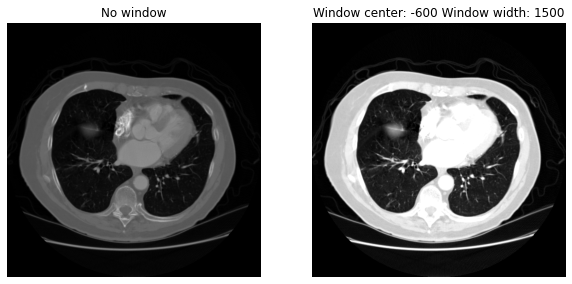

In [14]:
region = 'chest'
sub_region = 'lungs'
center, width = window_dict[region][sub_region]
print(f"{center=}")
print(f"{width=}")
image = window_image(scan_data, center, width)

f, axs = plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(scan_data[65,...],cmap=plt.cm.gray)
axs[0].set_title('No window')
axs[1].imshow(image[65,...],cmap=plt.cm.gray)
axs[1].set_title(f'Window center: {center} Window width: {width}')
for a in axs: a.axis('off')
f.show()

## Resampling

We're nearly ready to save our scans to NiFTI or Nrrd format, but first let's resample the scans to the appropriate pixel spacing and slice thickness. Going through the list of patient scans, you can notice that not all patients have the same pixel spacing. This can be problematic since regions of interest such as lesions or organs may be of completely different scale from patient to patient. 

In [14]:
for p in patient_path:
    scan = load_scan(p)
    print(scan[0].SliceThickness, scan[0].PixelSpacing)

[0.703125, 0.703125] 2.500000
[0.681641, 0.681641] 1.250000
[0.820312, 0.820312] 2.500000
[0.822266, 0.822266] 1.250000
[0.664062, 0.664062] 2.500000
[0.625000, 0.625000] 2.500000
[0.781250, 0.781250] 2.500000
[0.781250, 0.781250] 2.500000
[0.781250, 0.781250] 1.250000
[0.878906, 0.878906] 1.250000
[0.742188, 0.742188] 2.500000


In [22]:
def resample(image, scan, new_spacing=[1,1,1]):
    slice_thickness = float(scan[0].SliceThickness)
    pixel_spacing = np.array(scan[0].PixelSpacing, dtype=np.float32)
    spacing = np.concatenate(([slice_thickness], pixel_spacing), dtype=np.float32)
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [26]:
%%time
resample_image,_ = resample(scan_data, scan)
print(scan_data.shape, resample_image.shape)

(133, 512, 512) (332, 360, 360)
CPU times: user 12.9 s, sys: 391 ms, total: 13.2 s
Wall time: 13.3 s
